# First try


In [ ]:
# Step 1: Install required libraries (run this in a Jupyter cell or terminal)
!pip install transformers datasets evaluate -q
!pip install --upgrade datasets -q


In [ ]:
# Step 2: Import dependencies
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import torch

In [ ]:
# Step 3: Download the CSV file using huggingface_hub and load with pandas
from huggingface_hub import hf_hub_download
import pandas as pd
from datasets import Dataset

# Download the actual data file using hf_hub_download
file_path = hf_hub_download(repo_id="naimul011/BanglaToxicCommentsDB", filename="bangla_comments.csv", repo_type="dataset")

# Load the CSV using pandas
df = pd.read_csv(file_path)

# Convert the pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

print(dataset)  # Check available splits and features

# Step 4: Check a sample
print(dataset[0])

In [ ]:
# Step 4.5: Split the dataset into training and testing sets
dataset = dataset.train_test_split(test_size=0.2) # Using 20% of data for testing

print(dataset) # Check available splits after splitting

In [ ]:
# Step 5: Preprocessing - Tokenization
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example["comment_text"], truncation=True, padding="max_length")

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Step 6: Prepare labels for multi-label classification
# Define the list of label columns
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

def encode_labels(example):
    # Create a list of numerical labels (0 or 1) for each example based on the label columns
    # Handle None values by replacing them with 0 and convert to integers
    example["labels"] = [int(example[col]) if example[col] is not None else 0 for col in label_columns]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)

# Remove the original label columns and the 'Unnamed: 0' column
tokenized_datasets = tokenized_datasets.remove_columns(label_columns + ['Unnamed: 0'])

# Set the dataset format to numpy arrays - this might help bypass the tensor conversion issue
tokenized_datasets.set_format("numpy", columns=['input_ids', 'attention_mask', 'labels'])

# Create id2label and label2id mappings for the multi-labels
id2label = {i: label for i, label in enumerate(label_columns)}
label2id = {label: i for i, label in enumerate(label_columns)}

In [ ]:
# Step 7: Load Pretrained model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_columns),  # Number of labels is now the number of toxicity columns
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification" # Specify multi-label classification
)

In [ ]:
# Step 8: Training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Corrected from evaluation_strategy
    save_strategy="epoch", # Corrected from save_strategy
    num_train_epochs=3,
    per_device_train_batch_size=4, # Reduced batch size
    per_device_eval_batch_size=4, # Reduced batch size
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="example_based_accuracy", # Using one of the metrics we defined
    greater_is_better=True # Assuming higher accuracy is better
)

In [ ]:
# Step 9: Define metrics for multi-label classification
# For multi-label, accuracy and F1 score need to be calculated differently
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Apply sigmoid to the logits to get probabilities for multi-label
    sigmoid = lambda x: 1/(1 + np.exp(-x))
    predictions = (sigmoid(logits) > 0.5).astype(int) # Threshold at 0.5

    # Calculate accuracy (example-based) - count how many samples have all labels correct
    # acc = accuracy.compute(predictions=predictions, references=labels) # This computes label-based accuracy by default

    # To compute example-based accuracy, we can compare prediction rows with label rows
    correct_examples = np.all(predictions == labels, axis=1)
    example_based_accuracy = np.mean(correct_examples)

    # Calculate F1 score (macro or weighted are common for multi-label)
    # Using weighted average accounts for label imbalance
    f1_score_weighted = f1.compute(predictions=predictions, references=labels, average="weighted")
    f1_score_macro = f1.compute(predictions=predictions, references=labels, average="macro")


    return {"example_based_accuracy": example_based_accuracy, "f1_weighted": f1_score_weighted["f1"], "f1_macro": f1_score_macro["f1"]}

In [ ]:
# Step 10: Train the model

# Define a custom data collator to handle numpy to torch tensor conversion
from transformers import DataCollatorWithPadding

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # Call the parent class to handle padding of input_ids and attention_mask
        batch = super().__call__(features)

        # Convert labels from list of numpy arrays to a single torch tensor
        # Ensure the labels are of type torch.float for BCEWithLogitsLoss
        if "labels" in features[0].keys():
             # Stack the numpy arrays from each example into a single numpy array
            labels_list = [f["labels"] for f in features]
            # Convert the list of numpy arrays to a single numpy array
            labels_np = np.stack(labels_list)
            # Convert the numpy array to a torch tensor
            # Ensure the data type is float, as BCEWithLogitsLoss expects float targets
            batch["labels"] = torch.tensor(labels_np, dtype=torch.float)

        return batch

# Instantiate the custom data collator
data_collator = CustomDataCollator(tokenizer=tokenizer)


# Sample a smaller subset of the data for faster testing
train_subset_size = 1000  # Adjust as needed
eval_subset_size = 200   # Adjust as needed

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(train_subset_size))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(eval_subset_size))


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset, # Use the smaller dataset
    eval_dataset=small_eval_dataset,   # Use the smaller dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator # Use the custom data collator
)

trainer.train()

In [ ]:
pip install --upgrade datasets -q

In [ ]:
# Step 11: Evaluate on test data
results = trainer.evaluate()
print("Final evaluation:", results)


# Second Try



In [ ]:
# 📦 Step 1: Install necessary packages
!pip install datasets wordcloud matplotlib seaborn scikit-learn -q

# 📚 Step 2: Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import LabelBinarizer



In [ ]:
# 📥 Step 3: Load dataset from Hugging Face
dataset = load_dataset("naimul011/BanglaToxicCommentsDB", data_files=["diu_bangla_comments.csv", "bangla_comments.csv"])
df = pd.DataFrame(dataset["train"])

In [ ]:
display(df.head())
df.info()

,Unnamed: 0,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,আরিপ বাই আমি আফনার অনেক ভরোও একযন পেন। বাদশা ...,1.0,1,1.0,0.0,1.0,1.0
1,1,মাদারিরপুত...তোর বীচি দিয়া কুতকুত খেলমু খানকিখোর,1.0,1,1.0,1.0,1.0,1.0
2,2,সকালে ঘুম থেকে উঠতে না উঠতেই শালা তোর বোকচোদমা...,1.0,1,1.0,0.0,0.0,0.0
3,3,কি মাদারচুদ আমাকে টপ ফ্যান অফ দ্যা ওইক কেনো বা...,1.0,1,1.0,0.0,0.0,0.0
4,4,নাসার এক বিঙ্গানী জানিয়েছেন যে তারা তোমার বিচি...,1.0,1,0.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16807 entries, 0 to 16806
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     16807 non-null  int64  
 1   comment_text   16807 non-null  object 
 2   toxic          16797 non-null  float64
 3   severe_toxic   16807 non-null  int64  
 4   obscene        16800 non-null  float64
 5   threat         16797 non-null  float64
 6   insult         16804 non-null  float64
 7   identity_hate  16805 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.0+ MB


Sample dataset with less values

In [ ]:
# ✅ OPTIONAL: Sample a smaller portion of the dataset for quick testing
# Uncomment and change 'n' to limit size (e.g., 1000, 5000, etc.)
sample_size = 1000  # Choose your sample size
df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"Working with a sample of {len(df)} rows")


In [ ]:
display(df.head())
df.info()

In [ ]:
# 🧹 Step 4: Convert multilabel to single-label (multi-class)
def convert_to_single_label(row):
    if row['obscene'] == 1.0:
        return 'vulgar'
    elif row['toxic'] == 1.0 or row['severe_toxic'] == 1.0 or row['insult'] == 1.0:
        return 'toxic'
    elif row['threat'] == 1.0:
        return 'threat'
    elif row['identity_hate'] == 1.0:
        return 'hate'
    else:
        return 'clean'

df['label'] = df.apply(convert_to_single_label, axis=1)



/tmp/ipython-input-5-3268020931.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], order=df['label'].value_counts().index, palette='Set2')


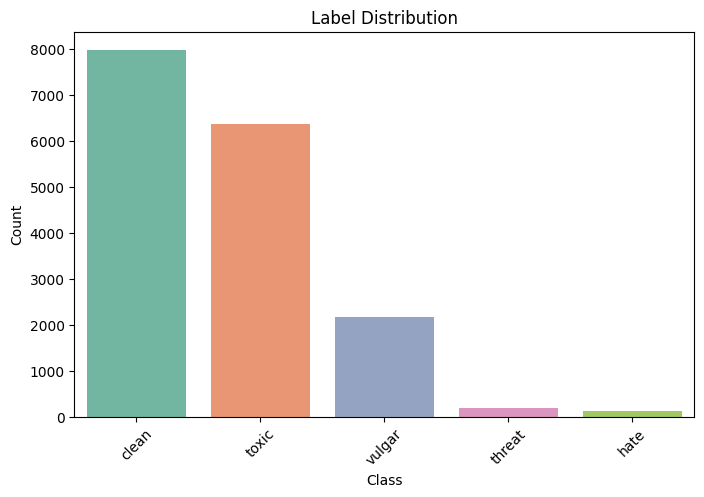

In [ ]:
# 🧪 Step 5: Show class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df['label'], order=df['label'].value_counts().index, palette='Set2')
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Download a Bengali font
!wget -q https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansBengali/NotoSansBengali-Regular.ttf -O NotoSansBengali-Regular.ttf

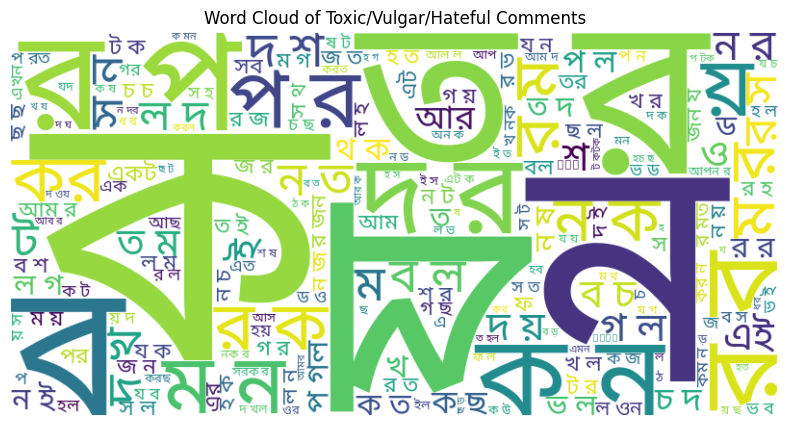

In [ ]:
# 🧾 Step 6: WordCloud of toxic comments
toxic_texts = ' '.join(df[df['label'] != 'clean']['comment_text'].astype(str))
wordcloud = WordCloud(font_path='NotoSansBengali-Regular.ttf', # Use the downloaded Bengali font
                      width=800, height=400, background_color='white').generate(toxic_texts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Toxic/Vulgar/Hateful Comments")
plt.show()

In [ ]:
# 🧹 Step 7: Text preprocessing (TF-IDF)
X = df['comment_text']
y = df['label']
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)

# 🎯 Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# 🤖 Step 9: Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# 📊 Step 10: Predict & Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       clean       0.71      0.83      0.77      1595
        hate       1.00      0.12      0.21        26
      threat       1.00      0.08      0.15        36
       toxic       0.64      0.68      0.66      1272
      vulgar       0.69      0.27      0.39       433

    accuracy                           0.68      3362
   macro avg       0.81      0.40      0.44      3362
weighted avg       0.69      0.68      0.67      3362



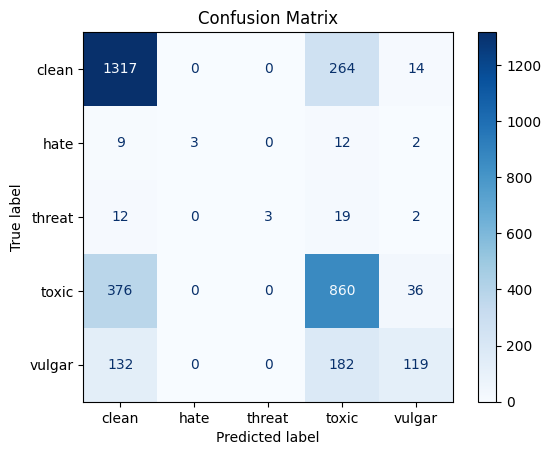

In [ ]:
# 📉 Step 11: Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/tmp/ipython-input-11-3780003114.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette='Set3')


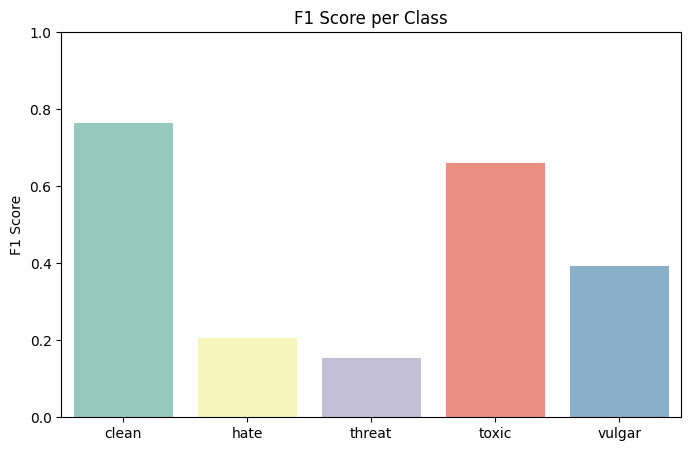

In [ ]:
# 📊 Step 12: F1-score per class (Bar Plot)
from sklearn.metrics import f1_score
labels = model.classes_
f1_scores = f1_score(y_test, y_pred, average=None, labels=labels)

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=f1_scores, palette='Set3')
plt.title("F1 Score per Class")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.show()

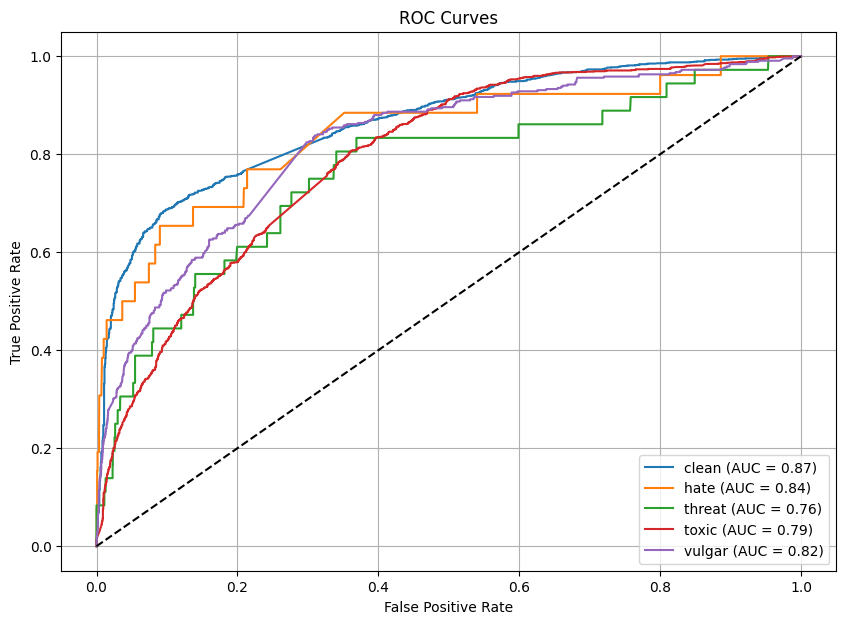

In [ ]:
# 📈 Step 13: ROC Curves (one-vs-rest)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_score = model.decision_function(X_test)

plt.figure(figsize=(10, 7))
for i, class_name in enumerate(lb.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### multiple model comparison


🔄 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.6847 | Macro F1: 0.4356 | Time: 7.67s
              precision    recall  f1-score   support

       clean       0.71      0.83      0.77      1595
        hate       1.00      0.12      0.21        26
      threat       1.00      0.08      0.15        36
       toxic       0.64      0.68      0.66      1272
      vulgar       0.69      0.27      0.39       433

    accuracy                           0.68      3362
   macro avg       0.81      0.40      0.44      3362
weighted avg       0.69      0.68      0.67      3362

🔄 Training Naive Bayes...
✅ Naive Bayes - Accuracy: 0.6499 | Macro F1: 0.3581 | Time: 0.08s
              precision    recall  f1-score   support

       clean       0.74      0.72      0.73      1595
        hate       0.00      0.00      0.00        26
      threat       1.00      0.08      0.15        36
       toxic       0.56      0.75      0.65      1272
      vulgar       0.78      0.16      0

/tmp/ipython-input-13-3286627362.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1 Score", data=results_df, palette="Set2")


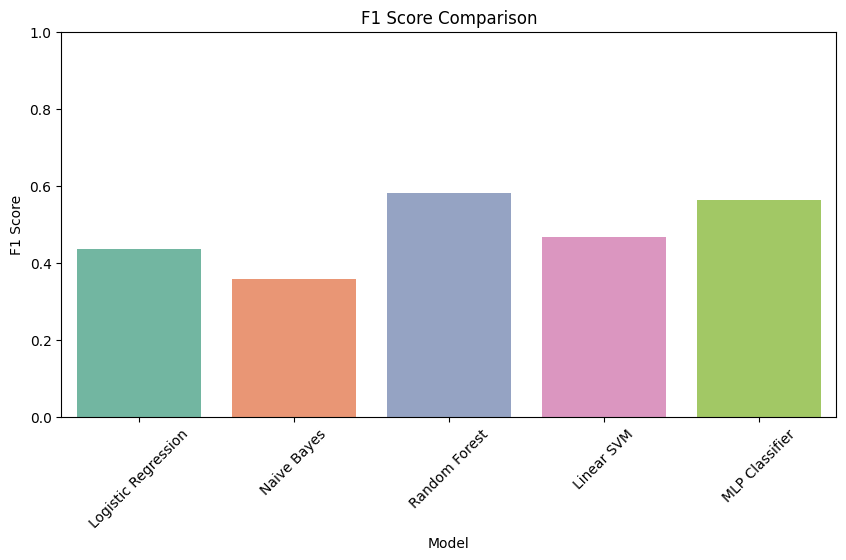

/tmp/ipython-input-13-3286627362.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Train Time (s)", data=results_df, palette="Set3")


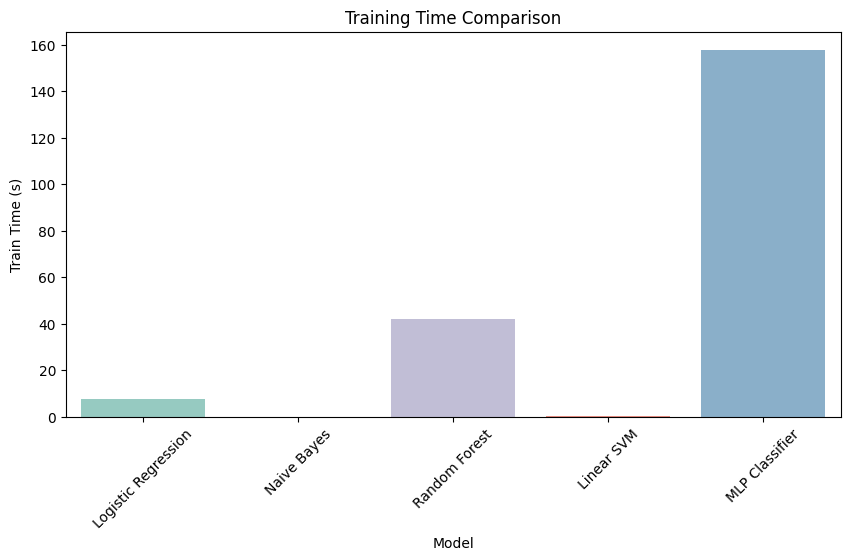

In [ ]:
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score

# List of models to try
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": LinearSVC(),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    print(f"🔄 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"✅ {name} - Accuracy: {acc:.4f} | Macro F1: {f1:.4f} | Time: {train_time:.2f}s")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score": f1,
        "Train Time (s)": train_time
    })

# 📊 Plot the results
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="F1 Score", data=results_df, palette="Set2")
plt.title("F1 Score Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Train Time (s)", data=results_df, palette="Set3")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)
plt.show()
